In [1]:
import os

# Dataset root path
data_dir = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# List to store all file paths
all_files = []

# Walk through every folder and subfolder
for root, dirs, files in os.walk(data_dir):
    for f in files:
        file_path = os.path.join(root, f)
        all_files.append(file_path)

# Show total number of files
print(f"✅ Total files found: {len(all_files)}")

# Show a few sample file paths
print("\n📂 Example file paths:")
for i, path in enumerate(all_files[:15]):
    print(f"{i+1}. {path}")

# Optional: summary by folder (robust version)
folder_summary = {}
for f in all_files:
    relative_path = os.path.dirname(f).replace(data_dir, '').strip(os.sep)
    parts = relative_path.split(os.sep)
    folder = parts[0] if len(parts) > 0 and parts[0] != '' else "root"
    folder_summary[folder] = folder_summary.get(folder, 0) + 1

print("\n📊 File count by top-level folder:")
for k, v in folder_summary.items():
    print(f"{k:20s} : {v}")

✅ Total files found: 87204

📂 Example file paths:
1. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/SHA256SUMS.txt
2. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/RECORDS
3. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/example_physionet.py
4. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_v103_changelog.txt
5. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv
6. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv
7. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/LICENSE.txt
8. /kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publ

In [2]:
# === Step 0: Install required library ===
!pip install wfdb

# === Step 1: Import libraries ===
import os
import pandas as pd
import numpy as np
import wfdb
import ast

# === Step 2: Define ECG data loader ===
def load_raw_data(df, sampling_rate, path):
    """
    Load ECG signals from PTB-XL dataset.
    Returns a NumPy array of shape (n_samples, n_timesteps, n_leads)
    """
    file_col = 'filename_lr' if sampling_rate == 100 else 'filename_hr'
    data = [wfdb.rdsamp(os.path.join(path, f))[0] for f in df[file_col]]
    return np.array(data)

# === Step 3: Setup dataset path and sampling rate ===
path = '/kaggle/input/ptb-xl-a-large-scale-ecg/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate = 100  # 100 Hz

# === Step 4: Load metadata and SCP codes ===
Y = pd.read_csv(os.path.join(path, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(lambda x: ast.literal_eval(x))

# === Step 5: Load ECG signal data ===
print("Loading ECG signal data...")
X = load_raw_data(Y, sampling_rate, path)
print(f"✅ Loaded {len(X)} ECG samples.")

# === Step 6: Load SCP statements and keep only diagnostic ones ===
agg_df = pd.read_csv(os.path.join(path, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]  # keep only diagnostic statements

# === Step 7: Map SCP codes to diagnostic superclass ===
def aggregate_diagnostic(y_dic):
    tmp = [] 
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)

# === Step 8: Keep only single-label ECGs ===
mask = Y['diagnostic_superclass'].apply(lambda x: len(x) == 1)
Y_filtered = Y[mask].copy()
X_filtered = X[mask.values]  # align signals

# === Step 9: Convert label list to string ===
Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].apply(lambda x: x[0])

# === Step 10: Display summary ===
print(f"\n✅ Filtered samples: {len(X_filtered)}")
print("📊 Label distribution:\n")
print(Y_filtered['diagnostic_superclass'].value_counts())

# === Optional: save for reuse ===
# np.save('X_filtered.npy', X_filtered)
# Y_filtered.to_csv('Y_filtered.csv')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.7 MB/s eta 0:00:00
Loading ECG signal data...
✅ Loaded 21799 ECG samples.

✅ Filtered samples: 16244
📊 Label distribution:

diagnostic_superclass
NORM    9069
MI      2532
STTC    2400
CD      1708
HYP      535
Name: count, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd

# === Step 8: Keep only single-label ECGs ===
mask = Y['diagnostic_superclass'].apply(lambda x: len(x) == 1)
Y_filtered = Y[mask].copy()
X_filtered = X[mask.values]  # align signals

# === Step 9: Convert label list to string ===
Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].apply(lambda x: x[0])

# === Step 10: Display summary ===
print(f"\n✅ Filtered samples: {len(X_filtered)}")
print("📊 Label distribution:\n")
print(Y_filtered['diagnostic_superclass'].value_counts())

# === Optional: save for reuse ===
# np.save('X_filtered.npy', X_filtered)
# Y_filtered.to_csv('Y_filtered.csv')
# === Step 1: Prepare data ===
X = X_filtered
y = Y_filtered['diagnostic_superclass']

# === Step 2: Split into train (30%) and temp (70%) ===
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.70,  # 70% goes to val+test
    random_state=42,
    stratify=y
)

# === Step 3: Split temp into val (10%) and test (60%) ===
# val = 10% of total, so 10/70 = 0.142857 ~0.143
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.8571,  # 0.8571*70% ≈ 60% total for test
    random_state=42,
    stratify=y_temp
)

# === Step 4: Display summary ===
print("✅ Split Summary:")
print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

print("\n📊 Label distribution:")
print("Train:\n", pd.Series(y_train).value_counts(), "\n")
print("Validation:\n", pd.Series(y_val).value_counts(), "\n")
print("Test:\n", pd.Series(y_test).value_counts())

print("\nShapes:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")



✅ Filtered samples: 16244
📊 Label distribution:

diagnostic_superclass
NORM    9069
MI      2532
STTC    2400
CD      1708
HYP      535
Name: count, dtype: int64
✅ Split Summary:
Train: 4873 samples
Validation: 1624 samples
Test: 9747 samples

📊 Label distribution:
Train:
 diagnostic_superclass
NORM    2721
MI       760
STTC     720
CD       512
HYP      160
Name: count, dtype: int64 

Validation:
 diagnostic_superclass
NORM    907
MI      253
STTC    240
CD      171
HYP      53
Name: count, dtype: int64 

Test:
 diagnostic_superclass
NORM    5441
MI      1519
STTC    1440
CD      1025
HYP      322
Name: count, dtype: int64

Shapes:
X_train: (4873, 1000, 12)
X_val: (1624, 1000, 12)
X_test: (9747, 1000, 12)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.3 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Data split: Train 30.00%, Val 10.00%, Test 60.00%
Model Params: 0.17M | GFLOPs per inference: 0.054
Epoch 1/50 | Train Loss: 0.9885 | Val Loss: 0.8228 | Val Acc: 73.34%
Epoch 2/50 | Train Loss: 0.7552 | Val Loss: 0.9365 | Val Acc: 68.41%
Epoch 3/50 | Train Loss: 0.7043 | Val Loss: 0.6782 | Val Acc: 75.74%
Epoch 4/50 | Train Loss: 0.6584 | Val Loss: 0.6475 | Val Acc: 76.85%
Epoch 5/50 | Train Loss: 0.6209 | Val Loss: 0.6589 | Val Acc: 77.28%
Epoch 6/50 | Train Loss: 0.6237 | Val Loss: 0.6108 | Val Acc: 78.02%
Epoch 7/50 | Train Loss: 0.6000 | Val Loss: 0.7287 | Val Acc: 73.65%
Epoch 8/50 | Train Loss: 0.5682 | Val Loss: 0.5914 | Val Acc: 78.82%
Epoch 9/50 | Train Loss: 0.5463 | Val Loss: 0.7099 | Val Acc: 75.80%
Epoch 10/50 | Train Loss: 0.5679 | Val Loss: 0.6397 | Val Acc: 76.97%
Epoch 11/50 | Train Loss: 0.5388 | Val Loss: 0.5982 | Val Acc: 78.57%
Epoch 12/50 | Train Loss: 0.5215 | Val Loss: 0.6277 | Val Acc: 78.76%
Epoch 13/50 | Train Loss: 0.4978 | Val Loss: 0.6486 | Val Acc: 79.00%

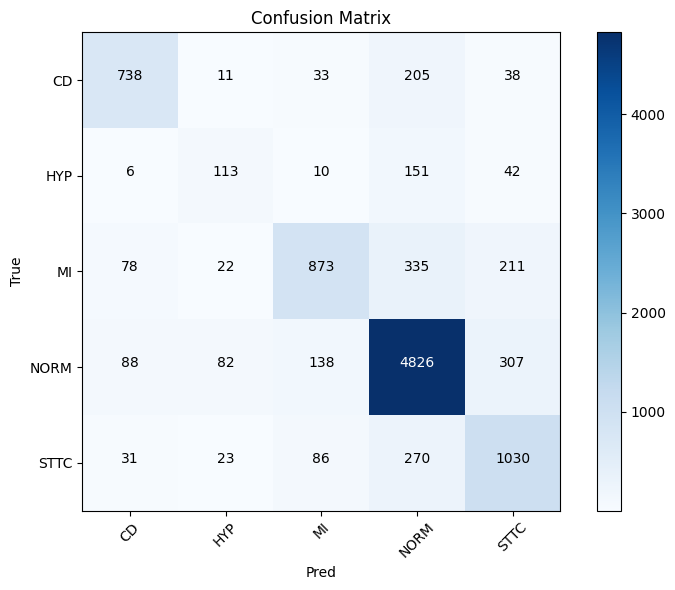

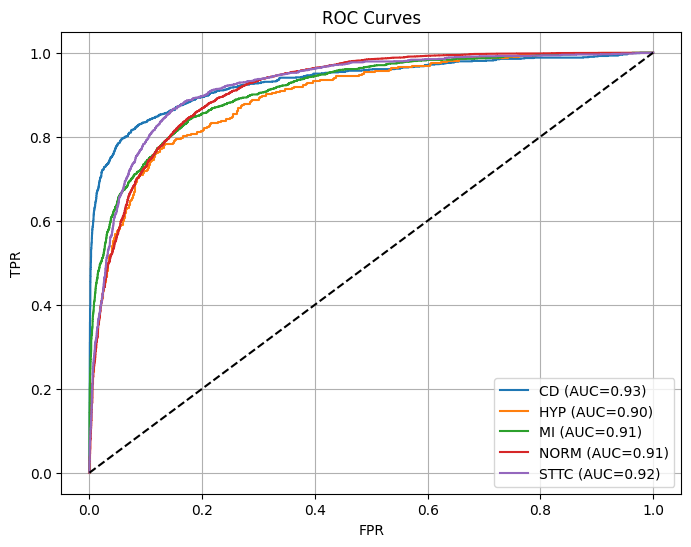

Model saved at ecgnet_outputs/ecgnet_30_10_60.pt
Training curves saved at ecgnet_outputs/training_epoch_stats.csv


In [4]:
# ==========================
# ECGNet: Full Training + Evaluation (30% Train, 10% Val, 60% Test)
# ==========================
!pip install ptflops --quiet

import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from ptflops import get_model_complexity_info

# ==========================
# 1️⃣ Data Preparation (30/10/60 split)
# ==========================
# X_filtered: (n_samples, seq_len, n_leads)
# Y_filtered['diagnostic_superclass']: pd.Series

# Step 1: Split into train (30%) and temp (70%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.70,
    random_state=42,
    stratify=Y_filtered['diagnostic_superclass']
)

# Step 2: Split temp into val (10%) and test (60%)
# 10% of total = 10/70 ≈ 0.14286 fraction of temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.85714,
    random_state=42,
    stratify=y_temp
)

print(f"Data split: Train {len(X_train)/len(X_filtered):.2%}, "
      f"Val {len(X_val)/len(X_filtered):.2%}, "
      f"Test {len(X_test)/len(X_filtered):.2%}")

# Fix channel ordering for Conv1d: (batch, channels, seq_len)
X_train_cnn = np.transpose(np.array(X_train), (0,2,1))
X_val_cnn   = np.transpose(np.array(X_val), (0,2,1))
X_test_cnn  = np.transpose(np.array(X_test), (0,2,1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_cnn, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_cnn, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)
test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

# ==========================
# 2️⃣ ECGNet Model
# ==========================
class ECGNet(nn.Module):
    def __init__(self, n_classes):
        super(ECGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(12, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ==========================
# 3️⃣ Model Setup
# ==========================
n_classes = len(le.classes_)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ECGNet(n_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 4️⃣ GFLOPs Estimation
# ==========================
try:
    in_ch = X_train_tensor.shape[1]
    seq_len = X_train_tensor.shape[2]
    model_cpu = model.to('cpu')
    macs, params = get_model_complexity_info(model_cpu, (in_ch, seq_len), as_strings=False, print_per_layer_stat=False)
    gflops = (macs * 2) / 1e9
    print(f"Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")
    model.to(device)
except Exception as e:
    print("GFLOPs estimation failed:", e)

# ==========================
# 5️⃣ Training Loop
# ==========================
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

train_start_time = time.time()
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100.0 * correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
train_end_time = time.time()
print(f"Training completed in {train_end_time - train_start_time:.2f} s")

# ==========================
# 6️⃣ Test Evaluation
# ==========================
model.eval()
all_preds, all_probs, all_labels = [], [], []
test_start_time = time.time()
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_labels.append(yb.numpy())
test_end_time = time.time()

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)
y_prob = np.concatenate(all_probs)
print(f"Test Accuracy: {(y_pred==y_true).mean()*100:.2f}%")
print(f"Test wall-clock: {test_end_time-test_start_time:.2f}s")

# ==========================
# 7️⃣ Metrics, Confusion Matrix, ROC–AUC
# ==========================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix"); plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, le.classes_, rotation=45); plt.yticks(tick_marks, le.classes_)
thresh = cm.max()/2
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, format(cm[i,j],'d'), ha='center', color='white' if cm[i,j]>thresh else 'black')
plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()

# ROC–AUC curves
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
fpr, tpr, roc_auc = {}, {}, {}
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend(); plt.grid(True); plt.show()

# ==========================
# 8️⃣ Save Model & Outputs
# ==========================
out_dir = "ecgnet_outputs"
os.makedirs(out_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(out_dir, "ecgnet_30_10_60.pt"))
print(f"Model saved at {os.path.join(out_dir, 'ecgnet_30_10_60.pt')}")

# Save training curves
df_epochs = pd.DataFrame({
    "epoch": np.arange(1,EPOCHS+1),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "val_acc_pct": val_accs
})
df_epochs.to_csv(os.path.join(out_dir, "training_epoch_stats.csv"), index=False)
print(f"Training curves saved at {os.path.join(out_dir,'training_epoch_stats.csv')}")


Train 30.00%, Val 10.00%, Test 60.00%
Model Params: 1.55M | GFLOPs per inference: 0.037
Epoch 1/50 | Train Loss: 1.2884 | Val Loss: 1.2395 | Val Acc: 55.91%
Epoch 2/50 | Train Loss: 1.1489 | Val Loss: 1.2369 | Val Acc: 56.22%
Epoch 3/50 | Train Loss: 0.9317 | Val Loss: 1.3186 | Val Acc: 51.11%
Epoch 4/50 | Train Loss: 0.6226 | Val Loss: 1.5707 | Val Acc: 48.77%
Epoch 5/50 | Train Loss: 0.3252 | Val Loss: 1.9221 | Val Acc: 45.14%
Epoch 6/50 | Train Loss: 0.1533 | Val Loss: 2.4196 | Val Acc: 45.50%
Epoch 7/50 | Train Loss: 0.0708 | Val Loss: 2.7207 | Val Acc: 47.35%
Epoch 8/50 | Train Loss: 0.0404 | Val Loss: 2.9820 | Val Acc: 44.58%
Epoch 9/50 | Train Loss: 0.0334 | Val Loss: 3.3603 | Val Acc: 46.80%
Epoch 10/50 | Train Loss: 0.0237 | Val Loss: 3.1751 | Val Acc: 44.70%
Epoch 11/50 | Train Loss: 0.0251 | Val Loss: 3.2637 | Val Acc: 46.06%
Epoch 12/50 | Train Loss: 0.0167 | Val Loss: 3.4675 | Val Acc: 47.41%
Epoch 13/50 | Train Loss: 0.0243 | Val Loss: 3.4185 | Val Acc: 45.50%
Epoch 14/50

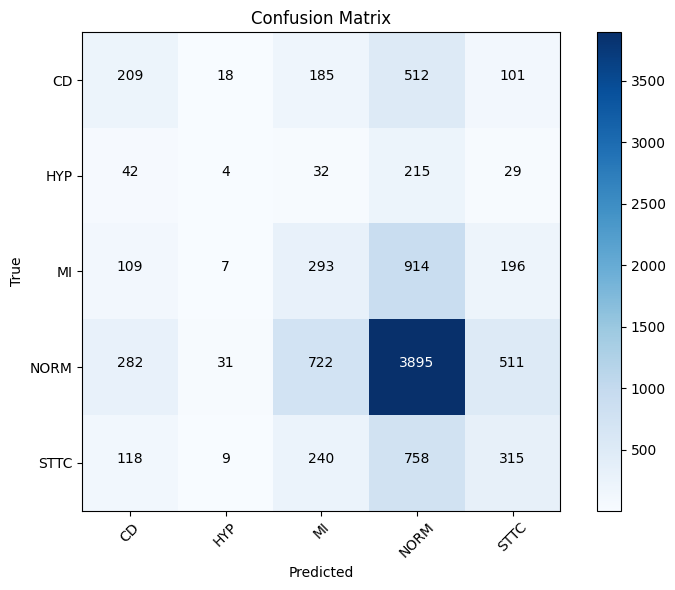

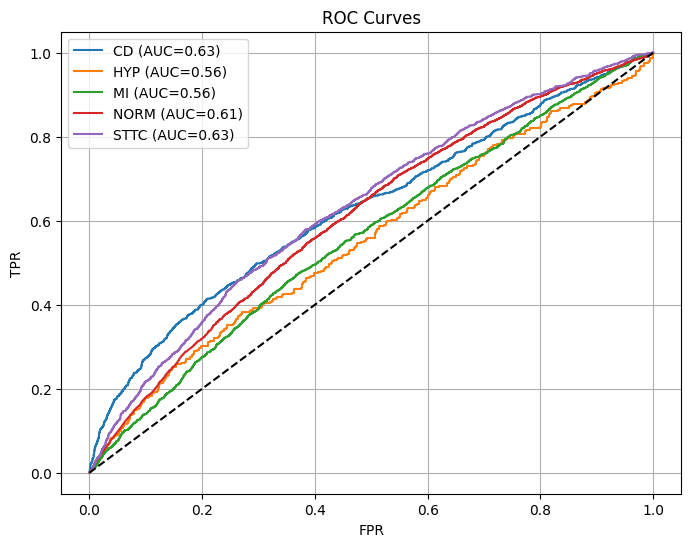

✅ Model saved as ecg_lstm_30_10_60.pt


In [5]:
# ==========================
# ECG LSTM: Full Training & Evaluation (30/10/60 split)
# ==========================
import os, time, itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from ptflops import get_model_complexity_info

# ==========================
# 1️⃣ Data Preparation
# ==========================
# X_filtered: (n_samples, seq_len, n_leads)
# Y_filtered['diagnostic_superclass']: pd.Series

# Split 30% train, 10% val, 60% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.70, random_state=42, stratify=Y_filtered['diagnostic_superclass']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.85714,  # 0.6 / 0.7 ≈ 0.85714 → 60% test
    random_state=42, stratify=y_temp
)
print(f"Train {len(X_train)/len(X_filtered):.2%}, Val {len(X_val)/len(X_filtered):.2%}, Test {len(X_test)/len(X_filtered):.2%}")

# LSTM expects (batch, seq_len, features)
X_train_lstm = np.transpose(np.array(X_train), (0, 2, 1))
X_val_lstm   = np.transpose(np.array(X_val), (0, 2, 1))
X_test_lstm  = np.transpose(np.array(X_test), (0, 2, 1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
n_classes = len(le.classes_)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val_lstm, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val_enc, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_enc, dtype=torch.long)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# ==========================
# 2️⃣ LSTM Model
# ==========================
class ECG_LSTM(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=2, n_classes=5, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size*2, n_classes)  # bidirectional

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ECG_LSTM(input_size=X_train_tensor.shape[2], n_classes=n_classes).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 3️⃣ GFLOPs estimation
# ==========================
try:
    macs, params = get_model_complexity_info(
        model, (X_train_tensor.shape[1], X_train_tensor.shape[2]),
        as_strings=False, print_per_layer_stat=False
    )
    gflops = (macs*2)/1e9
    print(f"Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")
except Exception as e:
    print("GFLOPs calculation skipped:", e)

# ==========================
# 4️⃣ Training Loop
# ==========================
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    correct, total, val_loss = 0,0,0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            preds = torch.argmax(logits, 1)
            correct += (preds==yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ==========================
# 5️⃣ Test Evaluation
# ==========================
model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits,1)
        preds = torch.argmax(logits,1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)
print(f"\nTest Accuracy: {(y_pred==y_true).mean()*100:.2f}%")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(n_classes), le.classes_, rotation=45)
plt.yticks(np.arange(n_classes), le.classes_)
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j], ha='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.ylabel("True"); plt.xlabel("Predicted"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

# ROC–AUC curves
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_prob[:,i])
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves"); plt.legend(); plt.grid(True); plt.show()

# Save model
torch.save(model.state_dict(), "ecg_lstm_30_10_60.pt")
print("✅ Model saved as ecg_lstm_30_10_60.pt")


Train 30.00%, Val 10.00%, Test 60.00%
Model Params: 23.51M | GFLOPs per inference: 2.335
Epoch 1/50 | Train Loss: 1.1622 | Val Loss: 1.1516 | Val Acc: 66.93%
Epoch 2/50 | Train Loss: 0.7967 | Val Loss: 1.2527 | Val Acc: 67.98%
Epoch 3/50 | Train Loss: 0.7209 | Val Loss: 0.7045 | Val Acc: 75.68%
Epoch 4/50 | Train Loss: 0.6528 | Val Loss: 0.7587 | Val Acc: 75.18%
Epoch 5/50 | Train Loss: 0.6502 | Val Loss: 0.9516 | Val Acc: 76.79%
Epoch 6/50 | Train Loss: 0.6343 | Val Loss: 0.6763 | Val Acc: 78.02%
Epoch 7/50 | Train Loss: 0.5677 | Val Loss: 0.6394 | Val Acc: 78.76%
Epoch 8/50 | Train Loss: 0.5424 | Val Loss: 0.6927 | Val Acc: 76.60%
Epoch 9/50 | Train Loss: 0.5155 | Val Loss: 0.7601 | Val Acc: 74.75%
Epoch 10/50 | Train Loss: 0.5075 | Val Loss: 0.8669 | Val Acc: 70.81%
Epoch 11/50 | Train Loss: 0.4783 | Val Loss: 0.7433 | Val Acc: 75.68%
Epoch 12/50 | Train Loss: 0.4360 | Val Loss: 0.8765 | Val Acc: 71.31%
Epoch 13/50 | Train Loss: 0.4425 | Val Loss: 1.0682 | Val Acc: 69.27%
Epoch 14/5

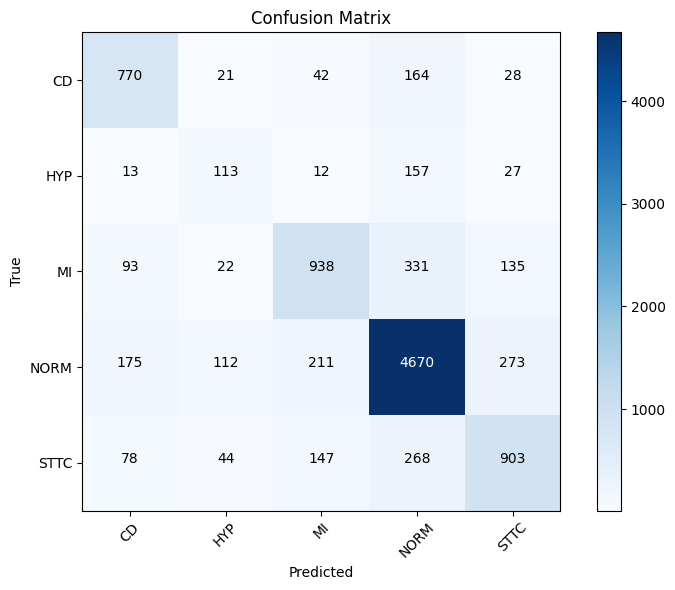

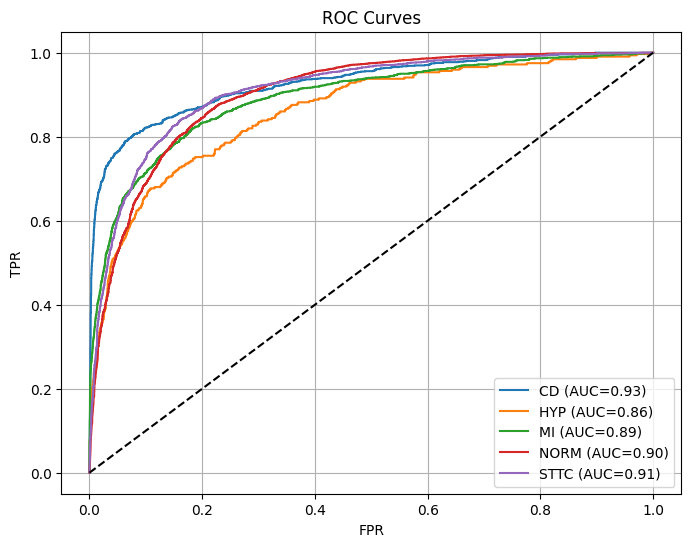

Model saved as ecg_resnet50_1d_30_10_60.pt


In [6]:
# ==========================
# ECG ResNet-50 1D: Full Training & Evaluation
# ==========================
import os, time, itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from ptflops import get_model_complexity_info

# ==========================
# 1️⃣ Data Preparation (30/10/60)
# ==========================
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.70, random_state=42, stratify=Y_filtered['diagnostic_superclass']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.85714,  # 60/70
    random_state=42, stratify=y_temp
)
print(f"Train {len(X_train)/len(X_filtered):.2%}, Val {len(X_val)/len(X_filtered):.2%}, Test {len(X_test)/len(X_filtered):.2%}")

# Transpose to [batch, channels, seq_len]
X_train = np.transpose(X_train, (0,2,1))
X_val   = np.transpose(X_val, (0,2,1))
X_test  = np.transpose(X_test, (0,2,1))

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
n_classes = len(le.classes_)

# Convert to tensors & dataloaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_enc, dtype=torch.long)), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_enc, dtype=torch.long)), batch_size=64)
test_loader  = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_enc, dtype=torch.long)), batch_size=64)

# ==========================
# 2️⃣ ResNet-50 1D Definition
# ==========================
from torchvision.models import resnet50

class ResNet1D50(nn.Module):
    def __init__(self, n_classes, in_channels=12):
        super().__init__()
        self.model = resnet50(weights=None)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7,1), stride=(2,1), padding=(3,0), bias=False)
        self.model.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.model.fc = nn.Linear(2048, n_classes)

    def forward(self, x):
        # Convert [batch, channels, seq_len] → [batch, channels, seq_len, 1] to match 2D conv
        x = x.unsqueeze(-1)
        x = self.model(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet1D50(n_classes=n_classes, in_channels=X_train.shape[1]).to(device)

# ==========================
# 3️⃣ GFLOPs & Params
# ==========================
try:
    macs, params = get_model_complexity_info(
        model, (X_train.shape[1], X_train.shape[2]), as_strings=False, print_per_layer_stat=False
    )
    gflops = (macs*2)/1e9
    print(f"Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")
except Exception as e:
    print("GFLOPs estimation skipped:", e)

# ==========================
# 4️⃣ Training
# ==========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    correct, total, val_loss = 0,0,0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            preds = torch.argmax(logits,1)
            correct += (preds==yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss/len(val_loader)
    val_acc = 100*correct/total
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ==========================
# 5️⃣ Test Evaluation
# ==========================
model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits,1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)
print(f"\nTest Accuracy: {(y_pred==y_true).mean()*100:.2f}%")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(n_classes), le.classes_, rotation=45)
plt.yticks(np.arange(n_classes), le.classes_)
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j], ha='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.ylabel("True"); plt.xlabel("Predicted"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

# ROC–AUC
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_prob[:,i])
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves"); plt.legend(); plt.grid(True); plt.show()

# Save model
torch.save(model.state_dict(), "ecg_resnet50_1d_30_10_60.pt")
print("Model saved as ecg_resnet50_1d_30_10_60.pt")


Train 30.00%, Val 10.00%, Test 60.00%
Model Params: 0.14M | GFLOPs per inference: 0.271
Epoch 1/50 | Train Loss: 1.2733 | Val Loss: 1.2585 | Val Acc: 55.73%
Epoch 2/50 | Train Loss: 1.2447 | Val Loss: 1.2535 | Val Acc: 55.79%
Epoch 3/50 | Train Loss: 1.2463 | Val Loss: 1.2613 | Val Acc: 55.85%
Epoch 4/50 | Train Loss: 1.2455 | Val Loss: 1.2504 | Val Acc: 55.97%
Epoch 5/50 | Train Loss: 1.2413 | Val Loss: 1.2589 | Val Acc: 55.85%
Epoch 6/50 | Train Loss: 1.2402 | Val Loss: 1.2466 | Val Acc: 56.03%
Epoch 7/50 | Train Loss: 1.2405 | Val Loss: 1.2491 | Val Acc: 56.03%
Epoch 8/50 | Train Loss: 1.2443 | Val Loss: 1.2547 | Val Acc: 55.42%
Epoch 9/50 | Train Loss: 1.2399 | Val Loss: 1.2521 | Val Acc: 55.79%
Epoch 10/50 | Train Loss: 1.2502 | Val Loss: 1.3132 | Val Acc: 54.37%
Epoch 11/50 | Train Loss: 1.2943 | Val Loss: 1.2594 | Val Acc: 55.11%
Epoch 12/50 | Train Loss: 1.2862 | Val Loss: 1.2529 | Val Acc: 55.85%
Epoch 13/50 | Train Loss: 1.2619 | Val Loss: 1.2648 | Val Acc: 55.79%
Epoch 14/50

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


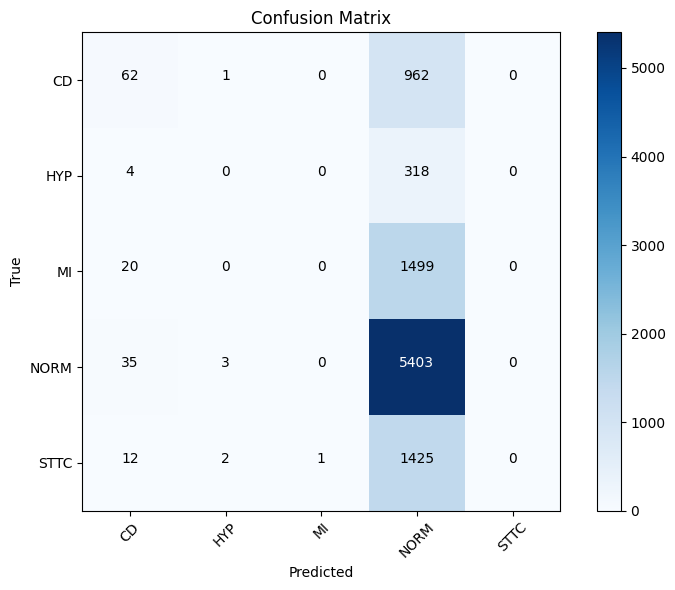

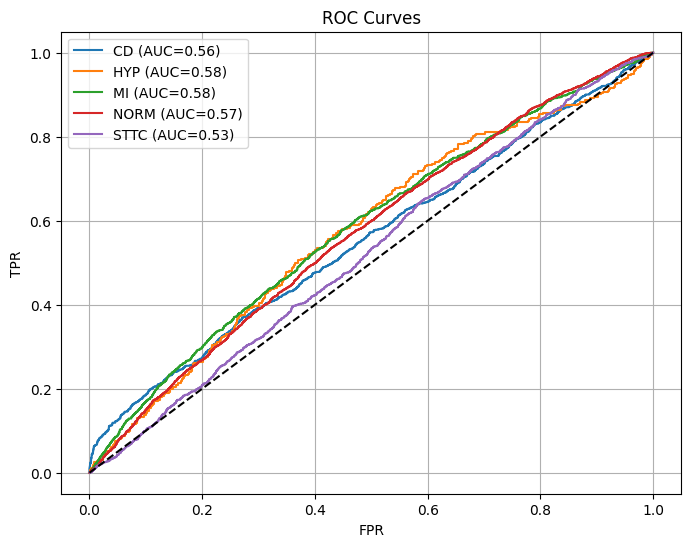

✅ Model saved as ecg_rnn_30_10_60.pt


In [7]:
# ==========================
# ECG RNN: Full Training & Evaluation (30/10/60 split)
# ==========================
import os, time, itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from ptflops import get_model_complexity_info

# ==========================
# 1️⃣ Data Preparation
# ==========================
# X_filtered: (n_samples, seq_len, n_leads)
# Y_filtered['diagnostic_superclass']: pd.Series

# Split 30% train, 10% val, 60% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_filtered, Y_filtered['diagnostic_superclass'],
    test_size=0.70, random_state=42, stratify=Y_filtered['diagnostic_superclass']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.85714,  # 0.6/0.7 = 0.85714 → 60% test
    random_state=42, stratify=y_temp
)
print(f"Train {len(X_train)/len(X_filtered):.2%}, Val {len(X_val)/len(X_filtered):.2%}, Test {len(X_test)/len(X_filtered):.2%}")

# RNN expects (batch, seq_len, features)
X_train_rnn = np.array(X_train)
X_val_rnn   = np.array(X_val)
X_test_rnn  = np.array(X_test)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)
n_classes = len(le.classes_)

# Convert to tensors & dataloaders
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_rnn, dtype=torch.float32),
                                        torch.tensor(y_train_enc, dtype=torch.long)), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.tensor(X_val_rnn, dtype=torch.float32),
                                        torch.tensor(y_val_enc, dtype=torch.long)), batch_size=64)
test_loader  = DataLoader(TensorDataset(torch.tensor(X_test_rnn, dtype=torch.float32),
                                        torch.tensor(y_test_enc, dtype=torch.long)), batch_size=64)

# ==========================
# 2️⃣ RNN Model
# ==========================
class ECG_RNN(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=2, n_classes=5, dropout=0.3):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=dropout,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size*2, n_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ECG_RNN(input_size=X_train_rnn.shape[2], n_classes=n_classes).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# ==========================
# 3️⃣ GFLOPs estimation
# ==========================
try:
    macs, params = get_model_complexity_info(
        model, (X_train_rnn.shape[1], X_train_rnn.shape[2]),
        as_strings=False, print_per_layer_stat=False
    )
    gflops = (macs*2)/1e9
    print(f"Model Params: {params/1e6:.2f}M | GFLOPs per inference: {gflops:.3f}")
except Exception as e:
    print("GFLOPs calculation skipped:", e)

# ==========================
# 4️⃣ Training Loop
# ==========================
EPOCHS = 50
train_losses, val_losses, val_accs = [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    correct, total, val_loss = 0,0,0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            preds = torch.argmax(logits, 1)
            correct += (preds==yb).sum().item()
            total += yb.size(0)
    avg_val_loss = val_loss/len(val_loader)
    val_acc = 100*correct/total
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# ==========================
# 5️⃣ Test Evaluation
# ==========================
model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.softmax(logits,1)
        preds = torch.argmax(logits,1)
        y_true.extend(yb.numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true, y_pred, y_prob = np.array(y_true), np.array(y_pred), np.array(y_prob)
print(f"\nTest Accuracy: {(y_pred==y_true).mean()*100:.2f}%")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(n_classes), le.classes_, rotation=45)
plt.yticks(np.arange(n_classes), le.classes_)
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, cm[i,j], ha='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.ylabel("True"); plt.xlabel("Predicted"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

# ROC–AUC curves
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_prob[:,i])
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC={auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves"); plt.legend(); plt.grid(True); plt.show()

# Save model
torch.save(model.state_dict(), "ecg_rnn_30_10_60.pt")
print("✅ Model saved as ecg_rnn_30_10_60.pt")
